In [34]:
import warnings
warnings.filterwarnings('ignore')

### Code for Truncated SVD

In [35]:
import numpy as np

# def truncated_svd(X, k):
#     # Calculate X^T X and X X^T
#     XtX = np.dot(X.T, X)
#     XXt = np.dot(X, X.T)
    
#     # Calculate eigendecomposition of X^T X
#     eigenvalues, eigenvectors = np.linalg.eig(XtX)
#     indices = eigenvalues.argsort()[::-1] # Sort eigenvalues in decreasing order
#     eigenvalues = eigenvalues[indices]
#     eigenvectors = eigenvectors[:,indices]
    
#     # Calculate square root of eigenvalues
#     sqrt_eigenvalues = np.sqrt(eigenvalues)
    
#     # Calculate V matrix
#     V = eigenvectors
    
#     # Calculate U matrix
#     U = np.dot(X, V) / sqrt_eigenvalues
    
#     # Truncate U, S, and V matrices
#     Uk = U[:, :k]
#     Sk = np.diag(sqrt_eigenvalues[:k])
#     Vk = V[:, :k]
    
#     X_k = np.dot(Uk, Sk)
    
#     return X_k

def truncated_svd(X, k):
    # Calculate X^T X and X X^T
    XtX = np.dot(X.T, X)
    XXt = np.dot(X, X.T)
    
    # Calculate eigendecomposition of X^T X
    eigenvalues, eigenvectors = np.linalg.eig(XtX)
    indices = eigenvalues.argsort()[::-1] # Sort eigenvalues in decreasing order
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:,indices]
    
    # Calculate square root of eigenvalues
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    
    # Calculate V matrix
    V = eigenvectors
    
    # Calculate U matrix
    U = np.dot(X, V) / sqrt_eigenvalues
    
    # Truncate U, S, and V matrices
    Uk = U[:, :k]
    Sk = np.diag(sqrt_eigenvalues[:k])
    Vk = V[:, :k]
    
    X_k = np.real(np.dot(Uk, Sk))
    
    return X_k


### Code for Finding the optimal n_components for SVD

In [36]:
import matplotlib.pyplot as plt

def truncated_svd_cev(X):
    singular_values = np.linalg.svd(X, compute_uv=False)

    cev = np.cumsum(singular_values**2) / np.sum(singular_values**2)

    plt.plot(cev)
    plt.xlabel('Number of singular values (k)')
    plt.ylabel('Cumulative explained variance (CEV)')
    plt.title('Elbow method for truncated SVD')
    plt.show()

### Code for Johnson Lindenstrauss Lemma

In [50]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim, SparseRandomProjection

def js_lemma(X):
    # Calculate the minimum number of dimensions required for Johnson-Lindenstrauss
    n_components = johnson_lindenstrauss_min_dim(X.shape[0], eps=0.5)

    # Perform sparse random projection
    srp = SparseRandomProjection(n_components=n_components)
    X_srp = srp.fit_transform(X)

    # print(n_components)

    return X_srp

### Kmeans

In [38]:
from sklearn.cluster import KMeans

def kmeans_implementation(X, X_reduced):
    wcss_X_values = []
    wcss_truncated_X_values = []

    for k in range(1, 21):
        # Perform k-means clustering on original df
        kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        wcss_X = kmeans.inertia_
        wcss_X_values.append(wcss_X)
        
        # Perform k-means clustering on truncated df
        kmeans_truncated = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
        kmeans_truncated.fit(X_reduced)
        wcss_truncated_X = kmeans_truncated.inertia_
        wcss_truncated_X_values.append(wcss_truncated_X)

    plt.plot(range(1, 21), wcss_X_values, label='X')
    plt.plot(range(1, 21), wcss_truncated_X_values, label='Reduced X')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.title('Comparison of WCSS values for X and Reduced X')
    plt.legend()
    plt.show()

### Credit Card Fraud Dataset

In [39]:
import pandas as pd

cc = pd.read_csv('./Data/CC GENERAL.csv')
cc = cc.drop(['CUST_ID'], axis=1)
cc.dropna(inplace=True)
cc.shape

(8636, 17)

##### Truncated SVD

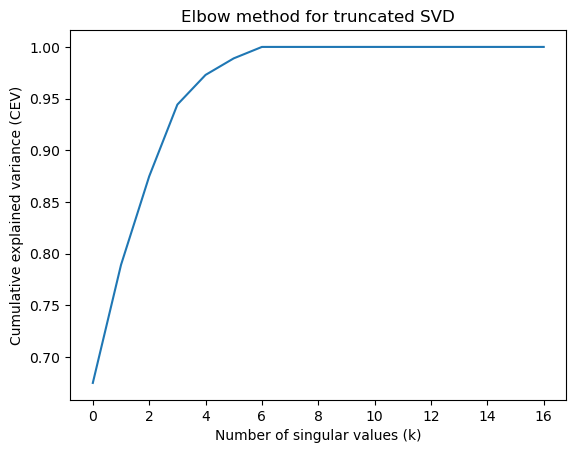

In [40]:
truncated_svd_cev(cc)

Optimal Number of Components for this dataset is 6

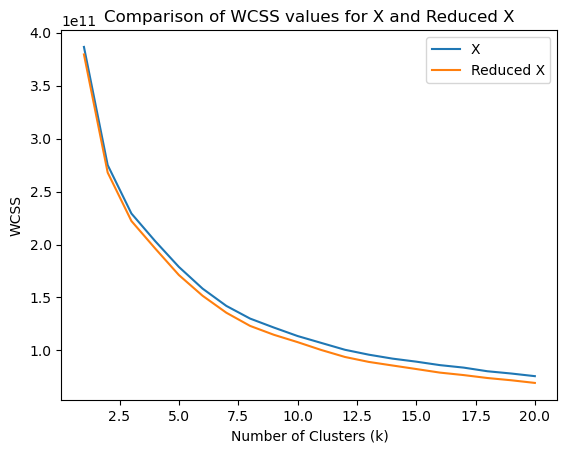

In [41]:
cc_reduced = truncated_svd(cc, 6)
kmeans_implementation(cc, cc_reduced)

### House Prices Fraud Dataset

In [42]:
from sklearn.preprocessing import OneHotEncoder

house_prices = pd.read_csv("./Data/HousePrices.csv")

# Separate the features and target
house_prices = house_prices.drop('SalePrice', axis=1)

# Encoding text data
ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
house_prices = ohe.fit_transform(house_prices).toarray()

##### Truncated SVD

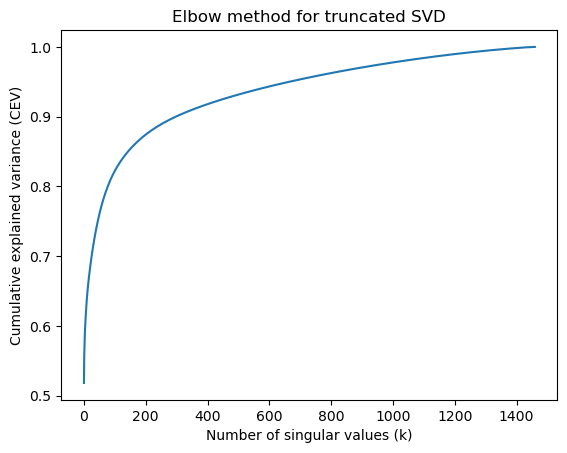

In [43]:
truncated_svd_cev(house_prices)

Optimal Number of components for this dataset is between 300 and 400

In [56]:
house_prices_reduced = truncated_svd(house_prices, 550)

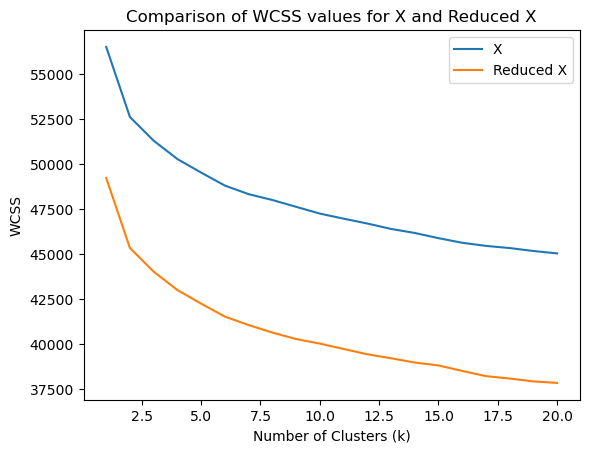

In [57]:
kmeans_implementation(house_prices, house_prices_reduced)

##### Johnson Lindenstrauss Lemma

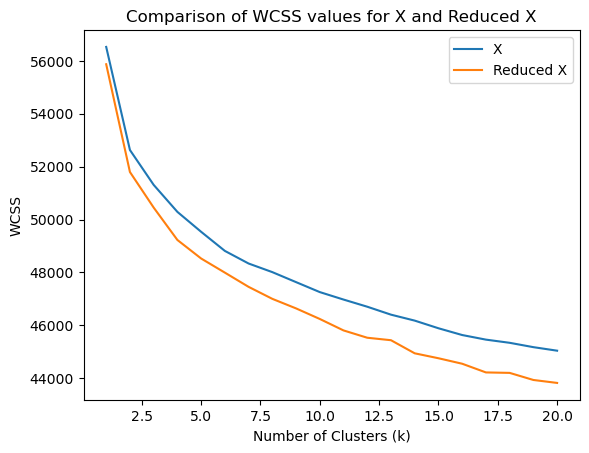

In [51]:
house_prices_reduced = js_lemma(house_prices)
kmeans_implementation(house_prices, house_prices_reduced)

### Digits Dataset

In [59]:
from sklearn.datasets import load_digits

# Load digits dataset
digits = load_digits()
digits = pd.DataFrame(digits.data)

##### Truncated SVD

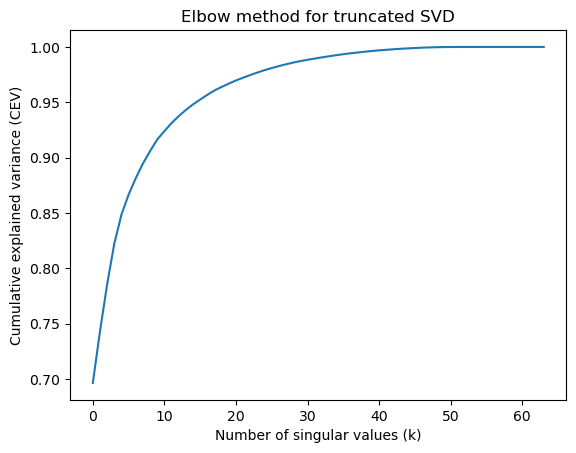

In [60]:
truncated_svd_cev(digits)

Optimal Number of components is around 30 to 40

In [61]:
digits_reduced = truncated_svd(digits, 35)

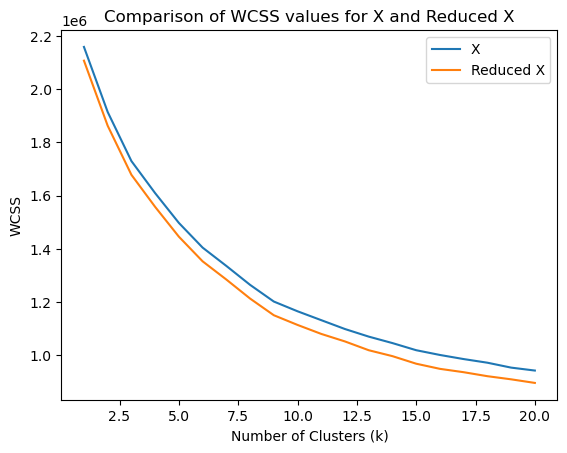

In [62]:
kmeans_implementation(digits, digits_reduced)

##### Johnson Lindenstrauss Lemma

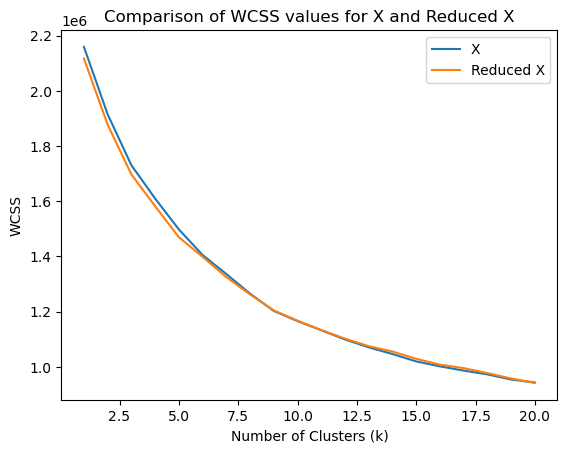

In [63]:
digits_reduced = js_lemma(digits)
kmeans_implementation(digits, digits_reduced)